In [26]:
import random

class Patient:
    def __init__(self):
        # clé = ID du médicament, valeur = probabilité de succès
        self.treatment_success_prob = {
            0: 0.10,
            1: 0.20,
            2: 0.15,
            3: 0.40,
            4: 0.35,
            5: 0.05,
            6: 0.25,
            7: 0.50,
            8: 0.70,
            9: 0.30
        }

    def apply_treatment(self, treatment_id):
        p = self.treatment_success_prob[treatment_id]
        return 1 if random.random() < p else 0


In [27]:

class MedicalTeam:
    """
    Stratégie :
    - Phase 1 (screening) : tester chaque traitement 3 fois.
      -> candidats = ceux à 3/3 ; si vide -> ceux à 2/3 ; si vide -> les meilleurs (top 3).
    - Phase 2 (re-test) : tester chaque candidat 5 fois.
      -> choisir le meilleur (succès max, tie-break aléatoire).
    - Phase 3 (exploitation) : appliquer le meilleur jusqu'à la fin.
    """

    def __init__(self, n_treatments=10, screen_trials=3, retest_trials=5, fallback_top_k=3):
        self.n_treatments = n_treatments
        self.screen_trials = screen_trials
        self.retest_trials = retest_trials
        self.fallback_top_k = fallback_top_k

        self.day = 0

        # Phase 1: on va tester 0,0,0,1,1,1,...,9,9,9
        self.phase = "screen"
        self.current_treatment = 0
        self.current_repeat_left = self.screen_trials

        self.screen_results = {i: 0 for i in range(n_treatments)}  # nb succès sur 3

        # Phase 2: candidats et retest
        self.candidates = []
        self.retest_queue = []
        self.retest_results = {}  # treatment -> [successes, trials]

        # Phase 3: meilleur traitement final
        self.best_treatment = None

    def select_treatment(self):
        """Retourne l'id du traitement à appliquer aujourd'hui."""
        if self.phase == "screen":
            return self.current_treatment

        if self.phase == "retest":
            # tête de queue = traitement en cours de retest
            return self.retest_queue[0]

        # exploitation
        return self.best_treatment

    def update(self, treatment_id, outcome):
        """
        Met à jour l'état après avoir reçu le résultat du patient.
        outcome: 0 ou 1
        """
        self.day += 1

        if self.phase == "screen":
            # enregistrer le succès du traitement testé
            self.screen_results[treatment_id] += int(outcome)

            # décrémenter le nombre de répétitions restantes pour ce traitement
            self.current_repeat_left -= 1

            # si on a fini les 3 essais pour ce traitement, passer au suivant
            if self.current_repeat_left == 0:
                self.current_treatment += 1
                self.current_repeat_left = self.screen_trials

                # si on a terminé les 10 traitements -> déterminer candidats et passer en retest
                if self.current_treatment >= self.n_treatments:
                    self._build_candidates_from_screen()
                    self._start_retest_phase()

        elif self.phase == "retest":
            t = self.retest_queue[0]
            self.retest_results[t][0] += int(outcome)  # successes
            self.retest_results[t][1] += 1             # trials

            # si on a fait assez de jours de retest pour ce candidat -> pop
            if self.retest_results[t][1] >= self.retest_trials:
                self.retest_queue.pop(0)

                # si plus rien à retester -> choisir le meilleur et passer en exploitation
                if not self.retest_queue:
                    self.best_treatment = self._choose_best_from_retest()
                    self.phase = "exploit"

        else:
            # phase exploit : rien de spécial à mettre à jour pour ta stratégie
            pass

    def _build_candidates_from_screen(self):
        # 1) candidats = 3/3
        self.candidates = [t for t, s in self.screen_results.items() if s == self.screen_trials]

        # 2) si vide => 2/3
        if not self.candidates:
            self.candidates = [t for t, s in self.screen_results.items() if s == self.screen_trials - 1]

        # 3) si toujours vide => fallback: top K par nombre de succès (tie-break random)
        if not self.candidates:
            items = list(self.screen_results.items())  # (t, successes)
            random.shuffle(items)  # tie-break aléatoire
            items.sort(key=lambda x: x[1], reverse=True)
            self.candidates = [t for t, _ in items[: self.fallback_top_k]]

    def _start_retest_phase(self):
        self.phase = "retest"
        self.retest_queue = list(self.candidates)  # on va retester chaque candidat 5 jours d’affilée
        self.retest_results = {t: [0, 0] for t in self.candidates}  # [successes, trials]

    def _choose_best_from_retest(self):
        # choisir le traitement avec le + de succès sur 5 (tie-break random)
        items = [(t, self.retest_results[t][0]) for t in self.candidates]
        random.shuffle(items)
        items.sort(key=lambda x: x[1], reverse=True)
        print("Traitement choisi après retest:", items[0][0], "avec", items[0][1], "succès sur 5")
        return items[0][0]


Our strategy is based on a two-stage exploration–exploitation process.
First, we perform a structured exploration phase by testing each treatment three consecutive times. This allows us to collect initial information about all treatments in a fair and systematic way. Treatments that achieve 3/3 successes are immediately considered strong candidates; if none achieve this, we retain those with 2/3 successes. This ensures that only promising treatments move forward.

In the second stage, we intensify exploration on the selected candidates by testing them five additional times. This reduces uncertainty and limits the risk of selecting a treatment that performed well purely by chance during the first phase.

Finally, we switch to exploitation by selecting the treatment with the highest number of successes during the re-test phase and using it for the remaining days.

This approach balances exploration (testing all treatments and re-evaluating promising ones) and exploitation (committing to the best-performing treatment once sufficient evidence is gathered), while keeping the method simple and computationally light.


Traitement choisi après retest: 7 avec 3 succès sur 5
Run 1: succès=47, best_treatment=7
Traitement choisi après retest: 8 avec 4 succès sur 5
Run 2: succès=60, best_treatment=8
Traitement choisi après retest: 8 avec 3 succès sur 5
Run 3: succès=50, best_treatment=8
Traitement choisi après retest: 7 avec 2 succès sur 5
Run 4: succès=44, best_treatment=7
Traitement choisi après retest: 4 avec 2 succès sur 5
Run 5: succès=39, best_treatment=4
Traitement choisi après retest: 7 avec 3 succès sur 5
Run 6: succès=43, best_treatment=7
Traitement choisi après retest: 8 avec 3 succès sur 5
Run 7: succès=51, best_treatment=8
Traitement choisi après retest: 8 avec 3 succès sur 5
Run 8: succès=51, best_treatment=8
Traitement choisi après retest: 0 avec 0 succès sur 5
Run 9: succès=9, best_treatment=0
Traitement choisi après retest: 3 avec 4 succès sur 5
Run 10: succès=39, best_treatment=3

Moyenne succès total: 43.3
Best treatments choisis: [7, 8, 8, 7, 4, 7, 8, 8, 0, 3]


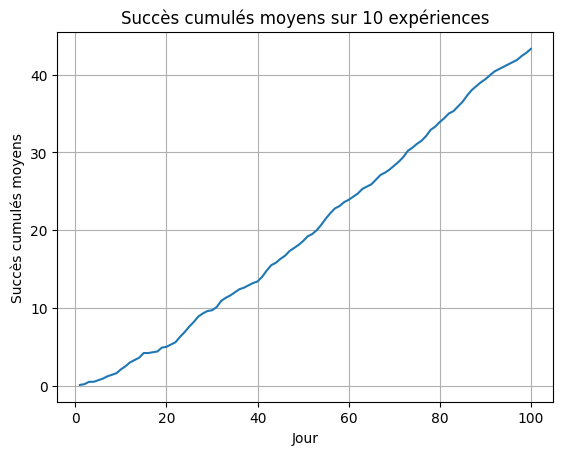

In [28]:
import matplotlib.pyplot as plt
import numpy as np

n_runs = 10
n_days = 100

all_curves = []
best_treatments = []
total_successes = []

for run in range(n_runs):
    patient = Patient()
    team = MedicalTeam(n_treatments=10, screen_trials=3, retest_trials=5, fallback_top_k=3)

    successes = 0
    curve = []

    for day in range(n_days):
        t = team.select_treatment()
        r = patient.apply_treatment(t)
        team.update(t, r)

        successes += r
        curve.append(successes)

    all_curves.append(curve)
    best_treatments.append(team.best_treatment)
    total_successes.append(successes)

    print(f"Run {run+1}: succès={successes}, best_treatment={team.best_treatment}")

# moyenne des courbes (moyenne point par point)
avg_curve = np.mean(all_curves, axis=0)

print("\nMoyenne succès total:", np.mean(total_successes))
print("Best treatments choisis:", best_treatments)

# plot
plt.figure()
plt.plot(range(1, n_days + 1), avg_curve)
plt.xlabel("Jour")
plt.ylabel("Succès cumulés moyens")
plt.title(f"Succès cumulés moyens sur {n_runs} expériences")
plt.grid(True)
plt.show()


**a) What is different in the information conveyed by the two following claims “getting 2 successes out of 4 trials” and “getting 20 successes out of 40 trials”?**

Although both situations have the same success rate (0.5), they do not convey the same level of confidence. In the case of 20 successes out of 40 trials, we have much more data, so our estimate of the treatment’s effectiveness is more reliable and less sensitive to randomness. In contrast, 2 successes out of 4 trials is based on very limited evidence, and the true success probability could still be significantly different from 0.5. The second statement therefore provides stronger statistical evidence.

---

**b) Can this information be completely represented by the fraction of successful trials (e.g., 2 successful days among 4 = 1/2)?**

No. The fraction alone does not capture the amount of evidence behind it. A success rate of 1/2 based on 4 trials is much less informative than the same rate based on 40 trials. The fraction ignores the total number of observations, which is essential to measure uncertainty. Therefore, we need at least the number of successes and the number of failures (or total trials), not just their ratio.

---

**c) If we now try to represent the information with a probability distribution over p (the probability of success), rather than simply a number, what should be the shape of this distribution in the case we don’t know anything about? What should be its shape in the case we collected a clear majority of successes?**

If we have no prior knowledge, the distribution over p should be uniform on the interval [0,1], meaning that all probabilities are equally plausible. This corresponds to a Beta(1,1) distribution.

If we collect a clear majority of successes, the distribution should become concentrated near high values of p (close to 1). Moreover, as the number of trials increases, the distribution should become narrower, reflecting reduced uncertainty. In the Beta framework, this corresponds to a distribution where the success parameter is much larger than the failure parameter, producing a strong peak near high probabilities.


### Bayesian Learning

In [29]:

class BayesianMedicalTeam:
    """
    Thompson Sampling (Beta-Bernoulli) :
    - Pour chaque traitement i, on maintient une croyance Beta(a_i, b_i) sur p_i.
    - Chaque jour :
        1) on sample theta_i ~ Beta(a_i, b_i) pour tous les i
        2) on choisit i* = argmax(theta_i)
        3) si succès: a_i* += 1 ; sinon: b_i* += 1
    """

    def __init__(self, n_treatments: int = 10, a0: int = 1, b0: int = 1, seed: int | None = None):
        self.n_treatments = n_treatments
        self.rng = np.random.default_rng(seed)

        # paramètres Beta pour chaque traitement
        self.a = np.full(n_treatments, a0, dtype=int)
        self.b = np.full(n_treatments, b0, dtype=int)

        # historique (utile pour plots / debug)
        self.last_choice = None
        self.choices = []
        self.outcomes = []
        self.a_history = [self.a.copy()]
        self.b_history = [self.b.copy()]

    def select_treatment(self) -> int:
        """Choisit le traitement via Thompson Sampling."""
        samples = self.rng.beta(self.a, self.b)          # theta_i échantillonnés
        choice = int(np.argmax(samples))                 # meilleur sample
        self.last_choice = choice
        return choice

    def update(self, treatment_id: int, outcome: int) -> None:
        """Met à jour Beta(a,b) selon le résultat (0/1)."""
        outcome = int(outcome)
        if outcome == 1:
            self.a[treatment_id] += 1
        else:
            self.b[treatment_id] += 1

        self.choices.append(treatment_id)
        self.outcomes.append(outcome)
        self.a_history.append(self.a.copy())
        self.b_history.append(self.b.copy())

    def get_params(self):
        """Renvoie (a, b) actuels (copies)."""
        return self.a.copy(), self.b.copy()


Succès total : 35
Traitement le plus choisi (sur 100 jours) : 8
Dernier traitement choisi : 8


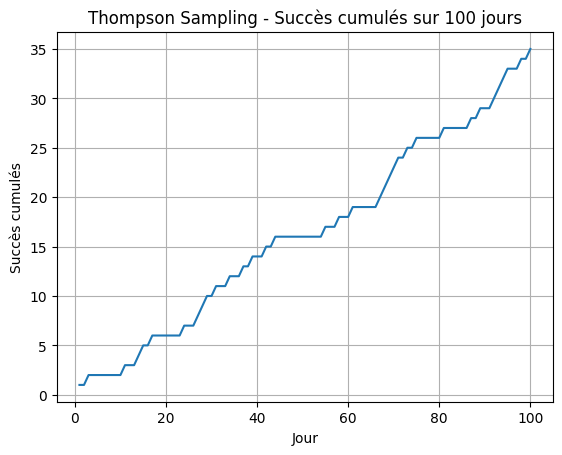

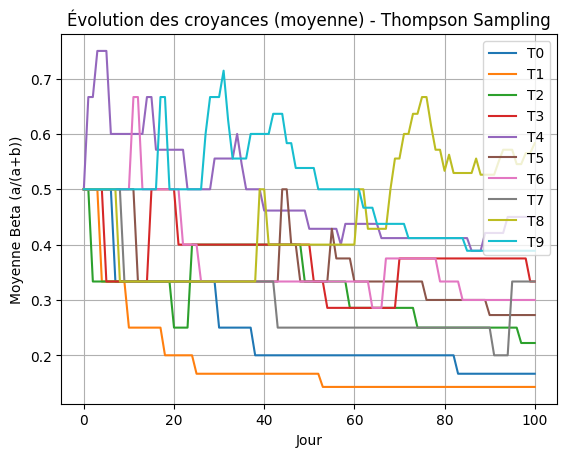

In [30]:
patient = Patient()
team = BayesianMedicalTeam(n_treatments=10, seed=42)

successes = 0
curve = []

for day in range(100):
    t = team.select_treatment()
    r = patient.apply_treatment(t)
    team.update(t, r)

    successes += r
    curve.append(successes)

print("Succès total :", successes)
print("Traitement le plus choisi (sur 100 jours) :", max(set(team.choices), key=team.choices.count))
print("Dernier traitement choisi :", team.last_choice)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, 101), curve)
plt.xlabel("Jour")
plt.ylabel("Succès cumulés")
plt.title("Thompson Sampling - Succès cumulés sur 100 jours")
plt.grid(True)
plt.show()


import numpy as np
import matplotlib.pyplot as plt

a_hist = np.array(team.a_history)  # (101, 10)
b_hist = np.array(team.b_history)  # (101, 10)
mean_hist = a_hist / (a_hist + b_hist)

plt.figure()
for i in range(mean_hist.shape[1]):
    plt.plot(range(mean_hist.shape[0]), mean_hist[:, i], label=f"T{i}")
plt.xlabel("Jour")
plt.ylabel("Moyenne Beta (a/(a+b))")
plt.title("Évolution des croyances (moyenne) - Thompson Sampling")
plt.grid(True)
plt.legend()
plt.show()


a) The algorithm selects treatments randomly but increases the probability of selecting a treatment as it performs well and confirms its efficiency.

In Thompson Sampling, each treatment is associated with a Beta distribution representing our belief about its success probability. Every day, the algorithm samples a random value from each treatment’s Beta distribution and selects the treatment with the highest sampled value. This introduces randomness in the decision process. However, when a treatment produces many successes, its Beta distribution shifts toward higher probabilities (its parameter a increases). As a result, samples drawn from this distribution are more likely to be large, which increases the probability that this treatment will be selected again. Therefore, the selection remains stochastic but becomes biased toward treatments that consistently perform well.

b) The algorithm progressively reduces the variance of each distribution as it learns about the degree of effectiveness of the corresponding treatment.

For a Beta distribution Beta(a, b), the variance decreases as the total number of observations (a + b) increases. Each time a treatment is tested, either a or b increases, making the distribution more concentrated around its mean 
𝑎/(𝑎+𝑏). At the beginning (Beta(1,1)), the distribution is wide and reflects high uncertainty. As more data is collected, the distribution becomes narrower, meaning that the uncertainty about the treatment’s true effectiveness decreases. Thus, learning is reflected not only in the shift of the mean but also in the reduction of variance.

c) The algorithm carries out both exploration and exploitation over the 100 days.

Exploration occurs because the algorithm samples randomly from all Beta distributions, which allows even uncertain or moderately performing treatments to occasionally be selected. This prevents the algorithm from prematurely committing to a suboptimal treatment. Exploitation occurs because treatments with strong past performance develop Beta distributions concentrated at high values, making them more likely to produce the largest sampled value. Over time, the algorithm naturally shifts from broad exploration (high uncertainty, wide distributions) to stronger exploitation (narrow distributions centered on the best treatment), achieving a principled balance between the two.